In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Rectangle

import cell_order_log_analysis
import sys
sys.path.append('../radio_api')
import constants

In [2]:
FIG_SIZE = (8,5)
FONT_SIZE = 16
LINE_STYLE = (0,(4,4))
LINE_WIDTH = 3.5
SAVE_FIG = False
X_MAX = 10 # Minutes to plot figures for

RESERVATION = 'RES130780'
exp_idx = '13min'
reservation_data_dir = '../data/' + RESERVATION + '/'
cell_order_log_filename = reservation_data_dir + 'cell-order-changingBudgets-lat-{}.log'.format(exp_idx)
cell_order_ue_log_filename = reservation_data_dir + 'cell-order-ue2-changingBudgets-lat-{}.log'.format(exp_idx)

if (SAVE_FIG):
    reservation_out_dir = '../outputs/' + RESERVATION + '/'
    if (not os.path.exists(reservation_out_dir)):
        os.mkdir(reservation_out_dir)

SLA_PERIOD = 30 # seconds over which the SLAs are negotiated
OUTLIER_PERCENTILE = 5 # Percentile to clip-off from both ends for each SLA period
N_PRB_PER_RBG = 3

In [3]:
def filter_bs_sla_stats(bs_data, budgets, ts_start):

    for user_id, supply_times in budgets['supply_times'].items():
        port_offset = int(user_id[0].split('.')[-1])
        sid = port_offset % constants.SLICE_NUM
        
        bs_data[sid]['filtered_ts_sec'] = []
        bs_data[sid]['filtered_lat_msec'] = []
        bs_data[sid]['filtered_thp_mbps'] = []
        for supply_time in supply_times:
            if ((supply_time + SLA_PERIOD) / 60 >= X_MAX):
                continue
            
            ts_filter = np.logical_and(bs_data[sid]['raw_ts_sec'] >= supply_time,
                                       bs_data[sid]['raw_ts_sec'] < supply_time + SLA_PERIOD + 1)
            if (not ts_filter.any()):
                continue

            sla_ts_sec = bs_data[sid]['raw_ts_sec'][ts_filter]
            bs_data[sid]['filtered_ts_sec'].append(np.max(sla_ts_sec))

            sla_lat_msec = bs_data[sid]['raw_lat_msec'][ts_filter]
            lat_outlier_filter = np.logical_and(sla_lat_msec <= np.percentile(sla_lat_msec, 100 - OUTLIER_PERCENTILE),
                                                sla_lat_msec >= np.percentile(sla_lat_msec, OUTLIER_PERCENTILE))
            if (lat_outlier_filter.any()):
                bs_data[sid]['filtered_lat_msec'].append(np.mean(sla_lat_msec[lat_outlier_filter]))
            else:
                bs_data[sid]['filtered_lat_msec'].append(np.median(sla_lat_msec))

            sla_thp_mbps = bs_data[sid]['raw_tx_mbps'][ts_filter]
            thp_outlier_filter = np.logical_and(sla_thp_mbps <= np.percentile(sla_thp_mbps, 100 - OUTLIER_PERCENTILE),
                                                sla_thp_mbps >= np.percentile(sla_thp_mbps, OUTLIER_PERCENTILE))
            if (thp_outlier_filter.any()):
                bs_data[sid]['filtered_thp_mbps'].append(np.mean(sla_thp_mbps[thp_outlier_filter]))
            else:
                bs_data[sid]['filtered_thp_mbps'].append(np.median(sla_thp_mbps))

        bs_data[sid]['filtered_ts_sec'] = np.array(bs_data[sid]['filtered_ts_sec'])
        bs_data[sid]['filtered_lat_msec'] = np.array(bs_data[sid]['filtered_lat_msec'])
        bs_data[sid]['filtered_thp_mbps'] = np.array(bs_data[sid]['filtered_thp_mbps'])

In [4]:
def filter_ue_sla_stats(ue_data, sid):

    ue_data[sid]['filtered_ts_sec'] = []
    ue_data[sid]['filtered_rtt_msec'] = []
    ue_data[sid]['filtered_mbps'] = []
    for supply_time in ue_data[sid]['supply_times']:
        if ((supply_time + SLA_PERIOD) / 60 >= X_MAX):
            continue
        
        ts_filter = np.logical_and(ue_data[sid]['raw_ts_sec'] >= supply_time,
                                   ue_data[sid]['raw_ts_sec'] < supply_time + SLA_PERIOD + 1)
        if (not ts_filter.any()):
            continue

        sla_ts_sec = ue_data[sid]['raw_ts_sec'][ts_filter]
        ue_data[sid]['filtered_ts_sec'].append(np.max(sla_ts_sec))

        sla_rtt_msec = ue_data[sid]['raw_rtt_msec'][ts_filter]
        lat_outlier_filter = np.logical_and(sla_rtt_msec <= np.percentile(sla_rtt_msec, 100 - OUTLIER_PERCENTILE),
                                            sla_rtt_msec >= np.percentile(sla_rtt_msec, OUTLIER_PERCENTILE))
        if (lat_outlier_filter.any()):
            ue_data[sid]['filtered_rtt_msec'].append(np.mean(sla_rtt_msec[lat_outlier_filter]))
        else:
            ue_data[sid]['filtered_rtt_msec'].append(np.median(sla_rtt_msec))

        sla_mbps = ue_data[sid]['raw_mbps'][ts_filter]
        thp_outlier_filter = np.logical_and(sla_mbps <= np.percentile(sla_mbps, 100 - OUTLIER_PERCENTILE),
                                            sla_mbps >= np.percentile(sla_mbps, OUTLIER_PERCENTILE))
        if (thp_outlier_filter.any()):
            ue_data[sid]['filtered_mbps'].append(np.mean(sla_mbps[thp_outlier_filter]))
        else:
            ue_data[sid]['filtered_mbps'].append(np.median(sla_mbps))

    ue_data[sid]['filtered_ts_sec'] = np.array(ue_data[sid]['filtered_ts_sec'])
    ue_data[sid]['filtered_rtt_msec'] = np.array(ue_data[sid]['filtered_rtt_msec'])
    ue_data[sid]['filtered_mbps'] = np.array(ue_data[sid]['filtered_mbps'])

In [5]:
bs_data, budgets, ts_start = cell_order_log_analysis.read_cell_order_log(cell_order_log_filename)
cell_order_log_analysis.summarize_over_sla_period(bs_data, SLA_PERIOD, OUTLIER_PERCENTILE)
user_id = list(budgets['supply_times'].keys())[0]
filter_bs_sla_stats(bs_data, budgets, ts_start)

cur_data, slice_id, _ = cell_order_log_analysis.read_cell_order_ue_log(cell_order_ue_log_filename, ts_start)
ue_data = {slice_id: cur_data}

active_slice = list(ue_data.keys())[0]
assert active_slice in bs_data.keys()
filter_ue_sla_stats(ue_data, slice_id)

Data for 758.353000164032 seconds has been extracted
UE Data for 754.8280000686646 seconds has been extracted


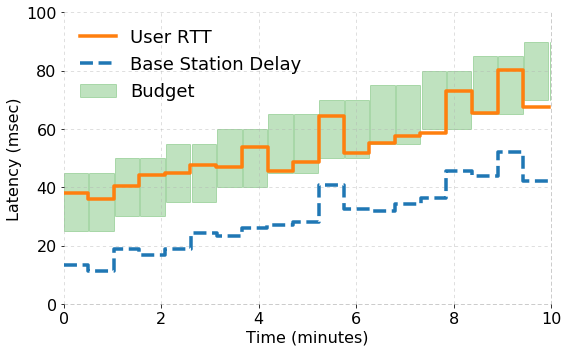

In [6]:
plt.figure(figsize = FIG_SIZE)

plt.step(np.insert(ue_data[active_slice]['filtered_ts_sec'] / 60, 0, 0), 
         np.insert(ue_data[active_slice]['filtered_rtt_msec'], 0, ue_data[active_slice]['filtered_rtt_msec'][0]), 
         where='pre', label='User RTT', linewidth=3.5, color='C1')
plt.step(np.insert(bs_data[active_slice]['filtered_ts_sec'] / 60, 0, 0), 
         np.insert(bs_data[active_slice]['filtered_lat_msec'], 0, bs_data[active_slice]['filtered_lat_msec'][0]), 
         where='pre', label='Base Station Delay', linewidth=3.5, color='C0', linestyle='--')

cnt = 1
min_budget = 20
for supply_time in budgets['supply_times'][user_id]:
    ts_minutes = (supply_time) / 60
    min_budget += (cnt % 2) * 5
    if (cnt == 1):
        plt.gca().add_patch(Rectangle((ts_minutes, min_budget), SLA_PERIOD / 60, 20, color='C2', alpha=0.3, label='Budget'))
    else:
        plt.gca().add_patch(Rectangle((ts_minutes, min_budget), SLA_PERIOD / 60, 20, color='C2', alpha=0.3))
    cnt += 1

plt.gca().set_xlabel('Time (minutes)', fontsize=FONT_SIZE)
plt.gca().set_ylabel('Latency (msec)', fontsize=FONT_SIZE)
plt.gca().tick_params(axis='y', labelsize=FONT_SIZE)
plt.gca().tick_params(axis='x', labelsize=FONT_SIZE)
plt.gca().set_ylim((0, 100))
plt.gca().set_xlim([0, X_MAX])
# plt.gca().xaxis.set_ticks(np.arange(0, 13))

plt.gca().legend(loc='upper left', frameon=False, fontsize=FONT_SIZE+2)

plt.gca().grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)

plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines["right"].set_linestyle(LINE_STYLE)
plt.gca().spines["right"].set_alpha(0.5)
plt.gca().spines["right"].set_color('gray')
plt.gca().spines["left"].set_linestyle(LINE_STYLE)
plt.gca().spines["left"].set_alpha(0.5)
plt.gca().spines["left"].set_color('gray')
plt.gca().spines["top"].set_linestyle(LINE_STYLE)
plt.gca().spines["top"].set_alpha(0.5)
plt.gca().spines["top"].set_color('gray')
plt.gca().spines["bottom"].set_linestyle(LINE_STYLE)
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["bottom"].set_color('gray')

plt.tight_layout()  # otherwise the right y-label is slightly clipped

if SAVE_FIG:
    plt.savefig(reservation_out_dir + 'provider_vs_user_lat.pdf')

plt.show()

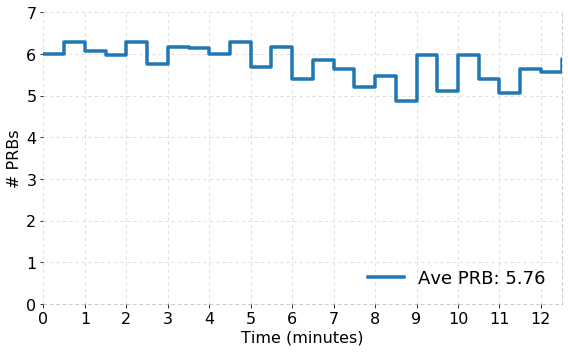

In [7]:
plt.figure(figsize = FIG_SIZE)

plt.step(np.insert(bs_data[active_slice]['ts_sec'] / 60, 0, 0), 
         np.insert(bs_data[active_slice]['n_rbgs'], 0, bs_data[active_slice]['n_rbgs'][0]), 
         label='Ave PRB: {:.2f}'.format(np.mean(bs_data[active_slice]['raw_n_rbgs'])), 
         where='pre', linewidth=3.5, color='C0', linestyle='-')

plt.gca().set_xlabel('Time (minutes)', fontsize=FONT_SIZE)
plt.gca().set_ylabel('# PRBs', fontsize=FONT_SIZE)
plt.gca().tick_params(axis='y', labelsize=FONT_SIZE)
plt.gca().tick_params(axis='x', labelsize=FONT_SIZE)
plt.gca().set_ylim((0, 7))
plt.gca().set_xlim([0, 12.5])
plt.gca().xaxis.set_ticks(np.arange(13))

plt.gca().legend(loc='lower right', frameon=False, fontsize=FONT_SIZE+2)

plt.gca().grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)

plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines["right"].set_linestyle(LINE_STYLE)
plt.gca().spines["right"].set_alpha(0.5)
plt.gca().spines["right"].set_color('gray')
plt.gca().spines["left"].set_linestyle(LINE_STYLE)
plt.gca().spines["left"].set_alpha(0.5)
plt.gca().spines["left"].set_color('gray')
plt.gca().spines["top"].set_linestyle(LINE_STYLE)
plt.gca().spines["top"].set_alpha(0.5)
plt.gca().spines["top"].set_color('gray')
plt.gca().spines["bottom"].set_linestyle(LINE_STYLE)
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["bottom"].set_color('gray')

plt.tight_layout()  # otherwise the right y-label is slightly clipped

if SAVE_FIG:
    plt.savefig(reservation_out_dir + 'prb.pdf')

plt.show()

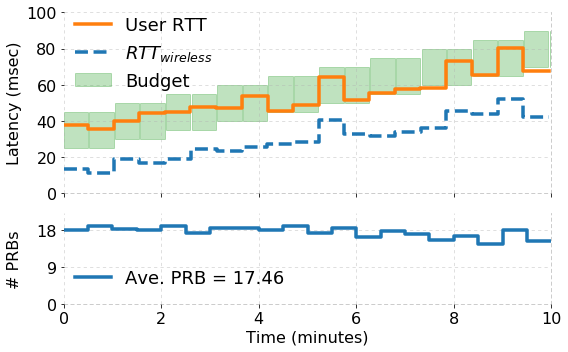

In [8]:
f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, figsize=FIG_SIZE)

ax1.step(np.insert(ue_data[active_slice]['filtered_ts_sec'] / 60, 0, 0), 
         np.insert(ue_data[active_slice]['filtered_rtt_msec'], 0, ue_data[active_slice]['filtered_rtt_msec'][0]), 
         where='pre', label='User RTT', linewidth=3.5, color='C1')
ax1.step(np.insert(bs_data[active_slice]['filtered_ts_sec'] / 60, 0, 0), 
         np.insert(bs_data[active_slice]['filtered_lat_msec'], 0, bs_data[active_slice]['filtered_lat_msec'][0]), 
         where='pre', label='$RTT_{wireless}$', linewidth=3.5, color='C0', linestyle='--')

cnt = 1
min_budget = 20
for supply_time in budgets['supply_times'][user_id]:
    ts_minutes = (supply_time) / 60
    min_budget += (cnt % 2) * 5
    if (cnt == 1):
        ax1.add_patch(Rectangle((ts_minutes, min_budget), SLA_PERIOD / 60, 20, color='C2', alpha=0.3, label='Budget'))
    else:
        ax1.add_patch(Rectangle((ts_minutes, min_budget), SLA_PERIOD / 60, 20, color='C2', alpha=0.3))
    cnt += 1

# ax1.set_xlabel('Time (minutes)', fontsize=FONT_SIZE)
ax1.set_ylabel('Latency (msec)', fontsize=FONT_SIZE)
ax1.tick_params(axis='y', labelsize=FONT_SIZE)
# ax1.tick_params(axis='x', labelsize=FONT_SIZE)
ax1.get_xaxis().set_ticklabels([])
ax1.set_ylim((0, 100))
ax1.set_xlim([0, X_MAX])
# ax1.xaxis.set_ticks(np.arange(0, 13))

ax1.legend(loc='upper left', frameon=False, fontsize=FONT_SIZE+2,
           bbox_to_anchor=[-0.01,1.07])

ax1.grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)

ax1.spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines["right"].set_linestyle(LINE_STYLE)
ax1.spines["right"].set_alpha(0.5)
ax1.spines["right"].set_color('gray')
ax1.spines["left"].set_linestyle(LINE_STYLE)
ax1.spines["left"].set_alpha(0.5)
ax1.spines["left"].set_color('gray')
ax1.spines["top"].set_linestyle(LINE_STYLE)
ax1.spines["top"].set_alpha(0.5)
ax1.spines["top"].set_color('gray')
ax1.spines["bottom"].set_linestyle(LINE_STYLE)
ax1.spines["bottom"].set_alpha(0.5)
ax1.spines["bottom"].set_color('gray')

ts_filter = bs_data[active_slice]['ts_sec'] < X_MAX * 60 + SLA_PERIOD

ax2.step(np.insert(bs_data[active_slice]['ts_sec'][ts_filter] / 60, 0, 0), 
         np.insert(bs_data[active_slice]['n_rbgs'][ts_filter] * N_PRB_PER_RBG, 
                   0, bs_data[active_slice]['n_rbgs'][0] * N_PRB_PER_RBG), 
         label='Ave. PRB = {:.2f}'.format(np.mean(bs_data[active_slice]['n_rbgs'][ts_filter] * N_PRB_PER_RBG)), 
         where='pre', linewidth=3.5, color='C0', linestyle='-')

ax2.set_xlabel('Time (minutes)', fontsize=FONT_SIZE)
ax2.set_ylabel('# PRBs', fontsize=FONT_SIZE)
ax2.tick_params(axis='y', labelsize=FONT_SIZE)
ax2.tick_params(axis='x', labelsize=FONT_SIZE)
ax2.set_ylim((0, 22))
ax2.yaxis.set_ticks(np.arange(0,22,9))
ax2.set_xlim([0, X_MAX])
# ax2.xaxis.set_ticks(np.arange(13))

ax2.legend(loc='lower left', frameon=False, fontsize=FONT_SIZE+2,
           bbox_to_anchor=[-0.01,0.0])

ax2.grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)

ax2.spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines["right"].set_linestyle(LINE_STYLE)
ax2.spines["right"].set_alpha(0.5)
ax2.spines["right"].set_color('gray')
ax2.spines["left"].set_linestyle(LINE_STYLE)
ax2.spines["left"].set_alpha(0.5)
ax2.spines["left"].set_color('gray')
ax2.spines["top"].set_linestyle(LINE_STYLE)
ax2.spines["top"].set_alpha(0.5)
ax2.spines["top"].set_color('gray')
ax2.spines["bottom"].set_linestyle(LINE_STYLE)
ax2.spines["bottom"].set_alpha(0.5)
ax2.spines["bottom"].set_color('gray')

f.tight_layout()  
f.align_ylabels()

if SAVE_FIG:
    plt.savefig(reservation_out_dir + 'provider_vs_user_lat_and_prb.pdf')

plt.show()

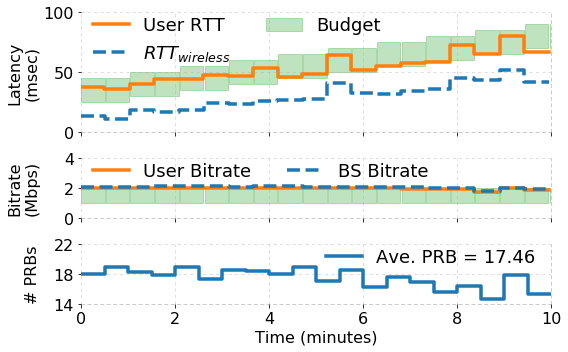

In [9]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [2, 1, 1]}, figsize=FIG_SIZE)

ax1.step(np.insert(ue_data[active_slice]['filtered_ts_sec'] / 60, 0, 0), 
         np.insert(ue_data[active_slice]['filtered_rtt_msec'], 0, ue_data[active_slice]['filtered_rtt_msec'][0]), 
         where='pre', label='User RTT', linewidth=3.5, color='C1')
ax1.step(np.insert(bs_data[active_slice]['filtered_ts_sec'] / 60, 0, 0), 
         np.insert(bs_data[active_slice]['filtered_lat_msec'], 0, bs_data[active_slice]['filtered_lat_msec'][0]), 
         where='pre', label='$RTT_{wireless}$', linewidth=3.5, color='C0', linestyle='--')

cnt = 1
min_budget = 20
for supply_time in budgets['supply_times'][user_id]:
    ts_minutes = (supply_time) / 60
    min_budget += (cnt % 2) * 5
    if (cnt == 1):
        ax1.add_patch(Rectangle((ts_minutes, min_budget), SLA_PERIOD / 60, 20, color='C2', alpha=0.3, label='Budget'))
    else:
        ax1.add_patch(Rectangle((ts_minutes, min_budget), SLA_PERIOD / 60, 20, color='C2', alpha=0.3))
    cnt += 1

# ax1.set_xlabel('Time (minutes)', fontsize=FONT_SIZE)
ax1.set_ylabel('Latency\n(msec)', fontsize=FONT_SIZE)
ax1.tick_params(axis='y', labelsize=FONT_SIZE)
# ax1.tick_params(axis='x', labelsize=FONT_SIZE)
ax1.get_xaxis().set_ticklabels([])
ax1.set_ylim((0, 100))
ax1.set_xlim([0,X_MAX])
# ax1.xaxis.set_ticks(np.arange(0, X_MAX+1))

ax1.legend(loc='upper left', frameon=False, fontsize=FONT_SIZE+2, ncol=2,
           bbox_to_anchor=[-0.01,1.1])

ax1.grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)

ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines["right"].set_linestyle(LINE_STYLE)
ax1.spines["right"].set_alpha(0.5)
ax1.spines["right"].set_color('gray')
ax1.spines["left"].set_linestyle(LINE_STYLE)
ax1.spines["left"].set_alpha(0.5)
ax1.spines["left"].set_color('gray')
ax1.spines["top"].set_linestyle(LINE_STYLE)
ax1.spines["top"].set_alpha(0.5)
ax1.spines["top"].set_color('gray')
ax1.spines["bottom"].set_linestyle(LINE_STYLE)
ax1.spines["bottom"].set_alpha(0.5)
ax1.spines["bottom"].set_color('gray')

ax2.step(np.insert(ue_data[active_slice]['filtered_ts_sec'] / 60, 0, 0), 
         np.insert(ue_data[active_slice]['filtered_mbps'], 0, ue_data[active_slice]['filtered_mbps'][0]), 
         where='pre', label='User Bitrate', linewidth=3.5, color='C1')
ax2.step(np.insert(bs_data[active_slice]['filtered_ts_sec'] / 60, 0, 0), 
         np.insert(bs_data[active_slice]['filtered_thp_mbps'], 0, bs_data[active_slice]['filtered_thp_mbps'][0]), 
         where='pre', label='BS Bitrate', linewidth=3.5, color='C0', linestyle='--')

cnt = 1
for supply_time in budgets['supply_times'][user_id]:
    ts_minutes = (supply_time) / 60
    ax2.add_patch(Rectangle((ts_minutes, 1), SLA_PERIOD / 60, 1, color='C2', alpha=0.3))
    cnt += 1

# ax2.set_xlabel('Time (minutes)', fontsize=FONT_SIZE)
ax2.set_ylabel('Bitrate\n(Mbps)', fontsize=FONT_SIZE)
ax2.tick_params(axis='y', labelsize=FONT_SIZE)
# ax1.tick_params(axis='x', labelsize=FONT_SIZE)
ax2.yaxis.set_ticks(np.arange(0,5,2))
ax2.get_xaxis().set_ticklabels([])
ax2.set_ylim((0, 4))
ax2.set_xlim([0,X_MAX])
# ax2.xaxis.set_ticks(np.arange(0, X_MAX+1))

ax2.legend(loc='upper left', frameon=False, fontsize=FONT_SIZE+2, ncol = 3,
           bbox_to_anchor=[-0.01,1.2])

ax2.grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)

ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines["right"].set_linestyle(LINE_STYLE)
ax2.spines["right"].set_alpha(0.5)
ax2.spines["right"].set_color('gray')
ax2.spines["left"].set_linestyle(LINE_STYLE)
ax2.spines["left"].set_alpha(0.5)
ax2.spines["left"].set_color('gray')
ax2.spines["top"].set_linestyle(LINE_STYLE)
ax2.spines["top"].set_alpha(0.5)
ax2.spines["top"].set_color('gray')
ax2.spines["bottom"].set_linestyle(LINE_STYLE)
ax2.spines["bottom"].set_alpha(0.5)
ax2.spines["bottom"].set_color('gray')

ts_filter = bs_data[active_slice]['ts_sec'] < X_MAX * 60 + SLA_PERIOD

ax3.step(np.insert(bs_data[active_slice]['ts_sec'][ts_filter] / 60, 0, 0), 
         np.insert(bs_data[active_slice]['n_rbgs'][ts_filter] * N_PRB_PER_RBG, 
                   0, bs_data[active_slice]['n_rbgs'][0] * N_PRB_PER_RBG), 
         label='Ave. PRB = {:.2f}'.format(np.mean(bs_data[active_slice]['n_rbgs'][ts_filter] * N_PRB_PER_RBG)), 
         where='pre', linewidth=3.5, color='C0', linestyle='-')

ax3.set_xlabel('Time (minutes)', fontsize=FONT_SIZE)
ax3.set_ylabel('# PRBs', fontsize=FONT_SIZE)
ax3.tick_params(axis='y', labelsize=FONT_SIZE)
ax3.tick_params(axis='x', labelsize=FONT_SIZE)
ax3.set_ylim((14, 22))
ax3.yaxis.set_ticks(np.arange(14,24,4))
ax3.set_xlim([0, X_MAX])
# ax3.xaxis.set_ticks(np.arange(0, X_MAX+1))

ax3.legend(loc='upper right', frameon=False, fontsize=FONT_SIZE+2,
           bbox_to_anchor=[1.0,1.2])

ax3.grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)

ax3.spines['top'].set_visible(False)
# ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines["right"].set_linestyle(LINE_STYLE)
ax3.spines["right"].set_alpha(0.5)
ax3.spines["right"].set_color('gray')
ax3.spines["left"].set_linestyle(LINE_STYLE)
ax3.spines["left"].set_alpha(0.5)
ax3.spines["left"].set_color('gray')
ax3.spines["top"].set_linestyle(LINE_STYLE)
ax3.spines["top"].set_alpha(0.5)
ax3.spines["top"].set_color('gray')
ax3.spines["bottom"].set_linestyle(LINE_STYLE)
ax3.spines["bottom"].set_alpha(0.5)
ax3.spines["bottom"].set_color('gray')

f.tight_layout()  
f.align_ylabels()

if SAVE_FIG:
    plt.savefig(reservation_out_dir + 'provider_vs_user_lat_thp_and_prb.pdf')

plt.show()